In [1]:
# Βιβλιοθήκες
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import io
from google.colab import files
from urllib.parse import urlparse

In [2]:
!pip install tensorflow
import tensorflow

In [6]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.models import Sequential, Model
from time import time
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Embedding, Dropout, MaxPooling1D, GlobalMaxPooling1D, Input, Concatenate
from tensorflow.keras.layers import GRU, BatchNormalization


In [3]:
# Upload το CSV αρχείο
uploaded = files.upload()

Saving my_new_data.csv to my_new_data.csv


In [7]:
# Διαβάζουμε το CSV αρχείο μέσω του Pandas DataFrame
df = pd.read_csv(io.BytesIO(uploaded['my_new_data.csv']))

# Παρουσίαση πρώτων 5 γραμμών
df.head()

,url,type,Category,url_len,num_subdomains,num_dots,digits,special_chars,letters,Https,Shortening_Service,having_ip
0,br-icloud.com.br,phishing,2,16,0,2,0,3,13,0,0,0
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,0,2,1,5,29,0,0,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,0,2,1,5,25,0,0,0
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,84,0,2,7,17,60,0,0,0
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235,0,2,22,14,199,0,0,0


In [8]:
# One-Hot Encoding των Ετικετών
y = to_categorical(df['Category'])

# Χαρακτηριστικό - ολόκληρο URL
# Παίρνουμε τη στήλη με τα URLs ως λίστα
urls = df['url'].astype(str).tolist()

# ψάχνουμε να βρούμε το καλύτερο μήκος για είσοδο ακολουθίας - max_len
# Υπολογισμός του μήκους κάθε URL
length = [len(url) for url in urls]

# Στατιστικά:
percentiles ={
    "max": max(length),
    "mean": np.mean(length),
    #Το 90%, 95%, 99% των URLs έχουν μήκος <= n χαρακτήρες.
    "90th": np.percentile(length, 90),
    "95th": np.percentile(length, 95),
    "99th": np.percentile(length,99)
}

percentiles

{'max': 2175,
 'mean': np.float64(58.98939042517848),
 '90th': np.float64(106.0),
 '95th': np.float64(133.0),
 '99th': np.float64(234.0)}

In [9]:
# Χρήση tokenizer χαρακτήρων (char-level)
char_tokenizer = Tokenizer(char_level=True, lower=False)
char_tokenizer.fit_on_texts(urls)

# Πλήθος μοναδικών χαρακτήρων
# Μέγεθος λεξικού (vocab_size)
vocab_size = len(char_tokenizer.word_index) + 1 # προσθέτουμε 1 για padding
# πίνακες με τα κωδικοποιημένα χαρακτηριστικά
url_sequences = char_tokenizer.texts_to_sequences(urls)
# μέγιστο μήκος
max_len = 230
# Padding ακολουθιών - ίδιο μήκος όλες οι ακολουθίες
# padding='post' - προσθήκη padding στο τέλος κάθε ακολουθίας
# truncating ='post' - περιορίζει το μήκος της ακολουθίας αφαιρώντας στοιχεία από το τέλος
padded_urls = pad_sequences(url_sequences, maxlen=max_len, padding='post', truncating='post')

In [10]:
# Το σύνολο των μοναδικών tokens (χαρακτήρων) που ενφανίζονται στα δεδομένα
print(char_tokenizer.word_index)

{'e': 1, 'o': 2, 't': 3, 'a': 4, '/': 5, 'i': 6, 'n': 7, 'c': 8, 's': 9, 'r': 10, 'm': 11, '.': 12, 'l': 13, 'p': 14, 'd': 15, '-': 16, 'h': 17, 'u': 18, 'g': 19, 'b': 20, '1': 21, '0': 22, 'f': 23, '2': 24, 'y': 25, 'w': 26, '=': 27, 'k': 28, '3': 29, '8': 30, 'v': 31, '5': 32, '4': 33, '9': 34, '_': 35, '%': 36, '6': 37, '&': 38, '7': 39, ':': 40, 'x': 41, '?': 42, 'j': 43, 'D': 44, 'z': 45, 'A': 46, 'B': 47, 'I': 48, 'C': 49, 'E': 50, 'S': 51, 'F': 52, 'M': 53, 'q': 54, 'L': 55, 'P': 56, 'R': 57, 'T': 58, 'N': 59, 'W': 60, '+': 61, 'G': 62, 'H': 63, 'O': 64, 'Z': 65, 'J': 66, 'Y': 67, 'V': 68, 'U': 69, 'Q': 70, 'X': 71, ';': 72, 'K': 73, '\\': 74, "'": 75, '~': 76, '(': 77, ')': 78, 'ะ': 79, ',': 80, '[': 81, ']': 82, '@': 83, '!': 84, 'พ': 85, '#': 86, 'ต': 87, '|': 88, 'ฝ': 89, ' ': 90, 'ธ': 91, 'ฐ': 92, 'ร': 93, 'ผ': 94, '*': 95, 'é': 96, 'บ': 97, 'ฒ': 98, 'Ã': 99, 'Â': 100, '}': 101, '{': 102, '\x82': 103, '\x83': 104, 'ฑ': 105, '$': 106, 'ณ': 107, 'ฟ': 108, 'ป': 109, 'ฮ': 110, 

**Εκπαίδευση**

In [12]:
def train_and_evaluate(model, X_train, X_test, y_train, y_test, model_name):
    start_time= time()

    # Εκπαίδευση του μοντέλου
    model.fit(X_train, y_train, epochs=7, batch_size=128, validation_data=(X_test, y_test), verbose=1, shuffle=False)
    training_time = time() - start_time

    # Αξιολόγηση μοντέλου στο test set
    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)

    # Προβλέψεις - επιστρέφει πιθανότητες (softmax)
    y_pred_prob = model.predict(X_test)
    # Κατηγορία με τη μεγαλύτερη πιθανότητα
    y_pred = np.argmax(y_pred_prob, axis=1)
    # Πραγματική κατηγορία από one-hot y_test
    y_true = np.argmax(y_test, axis=1)

    # Υπολογισμός μετρικών
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall= recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1= f1_score(y_true, y_pred, average='weighted', zero_division=0)

    # Εκτύπωση λεπτομερούς αναφοράς
    print(f"\nClassification Report for {model_name}:\n")
    print(classification_report(y_true, y_pred, zero_division=0))

    # Πίνακας - Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f"Confusion Matrix: {model_name}")
    plt.show()

    return model_name, round(accuracy, 4), round(precision, 4), round(recall, 4) , round(f1, 4), round(training_time, 2)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/7
4007/4007 ━━━━━━━━━━━━━━━━━━━━ 2453s 611ms/step - accuracy: 0.8602 - loss: 0.3991 - val_accuracy: 0.9546 - val_loss: 0.1324
Epoch 2/7
4007/4007 ━━━━━━━━━━━━━━━━━━━━ 2271s 567ms/step - accuracy: 0.9545 - loss: 0.1275 - val_accuracy: 0.9463 - val_loss: 0.1389
Epoch 3/7
4007/4007 ━━━━━━━━━━━━━━━━━━━━ 2267s 566ms/step - accuracy: 0.9628 - loss: 0.1034 - val_accuracy: 0.9646 - val_loss: 0.0999
Epoch 4/7
4007/4007 ━━━━━━━━━━━━━━━━━━━━ 2357s 580ms/step - accuracy: 0.9677 - loss: 0.0905 - val_accuracy: 0.9647 - val_loss: 0.0973
Epoch 5/7
4007/4007 ━━━━━━━━━━━━━━━━━━━━ 2265s 565ms/step - accuracy: 0.9707 - loss: 0.0814 - val_accuracy: 0.9664 - val_loss: 0.0920
Epoch 6/7
4007/4007 ━━━━━━━━━━━━━━━━━━━━ 2331s 582ms/step - accuracy: 0.9732 - loss: 0.0737 - val_accuracy: 0.9670 - val_loss: 0.0931
Epoch 7/7
4007/4007 ━━━━━━━━━━━━━━━━━━━━ 2331s 582ms/step - accuracy: 0.9751 - loss: 0.0685 - val_accuracy: 0.9685 - val_loss: 0.0907
4007/4007 ━━━━━━━━━━━━━━━━━━━━ 198s 49ms/step

Classification 

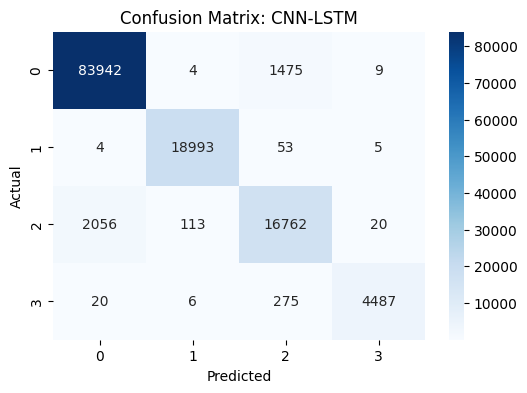

      Model  Accuracy  Precision  Recall  F1-Score  Training Time
0  CNN-LSTM    0.9685     0.9683  0.9685    0.9683        16276.7


In [14]:
# Εκπαίδευση με URL χαρακτηριστικό
X_train_url, X_test_url, y_train, y_test = train_test_split(padded_urls, y, test_size=0.2, random_state=42)

# Δημιουργία του CNN-LSTM Μοντέλου
cnn_lstm_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=128, input_length=max_len),
    Conv1D(128, kernel_size=3, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Conv1D(128, kernel_size=3, activation='relu', padding='same'),
    MaxPooling1D(pool_size=2),
    # Προσθήκη LSTM
    LSTM(128),
    # Πλήρως συνδεδεμένο επίπεδο
    Dense(64, activation='relu'),
    Dropout(0.3), # Regularization
    # Τελική έξοδος
    Dense(4, activation='softmax')
])

# Σύνταξη του μοντέλου
cnn_lstm_model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0005), metrics=['accuracy'])

results = []
# Εκπαίδευση και Αξιολόγηση, προσθήκη στη τελική λίστα αποτελεσμάτων
results.append(train_and_evaluate(cnn_lstm_model, X_train_url, X_test_url, y_train, y_test, 'CNN-LSTM'))

# Παρουσίαση αποτελεσμάτων
results_df = pd.DataFrame(results, columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'Training Time'])
print(results_df)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/7
4007/4007 ━━━━━━━━━━━━━━━━━━━━ 3004s 749ms/step - accuracy: 0.7203 - loss: 0.8190 - val_accuracy: 0.8852 - val_loss: 0.3464
Epoch 2/7
4007/4007 ━━━━━━━━━━━━━━━━━━━━ 3005s 750ms/step - accuracy: 0.9251 - loss: 0.2076 - val_accuracy: 0.9324 - val_loss: 0.1875
Epoch 3/7
4007/4007 ━━━━━━━━━━━━━━━━━━━━ 2992s 747ms/step - accuracy: 0.9403 - loss: 0.1650 - val_accuracy: 0.9456 - val_loss: 0.1468
Epoch 4/7
4007/4007 ━━━━━━━━━━━━━━━━━━━━ 3017s 746ms/step - accuracy: 0.9485 - loss: 0.1393 - val_accuracy: 0.9512 - val_loss: 0.1345
Epoch 5/7
4007/4007 ━━━━━━━━━━━━━━━━━━━━ 3022s 746ms/step - accuracy: 0.9541 - loss: 0.1240 - val_accuracy: 0.9578 - val_loss: 0.1148
Epoch 6/7
4007/4007 ━━━━━━━━━━━━━━━━━━━━ 3025s 746ms/step - accuracy: 0.9580 - loss: 0.1125 - val_accuracy: 0.9576 - val_loss: 0.1175
Epoch 7/7
4007/4007 ━━━━━━━━━━━━━━━━━━━━ 2992s 747ms/step - accuracy: 0.9614 - loss: 0.1032 - val_accuracy: 0.9628 - val_loss: 0.0998
4007/4007 ━━━━━━━━━━━━━━━━━━━━ 233s 58ms/step

Classification 

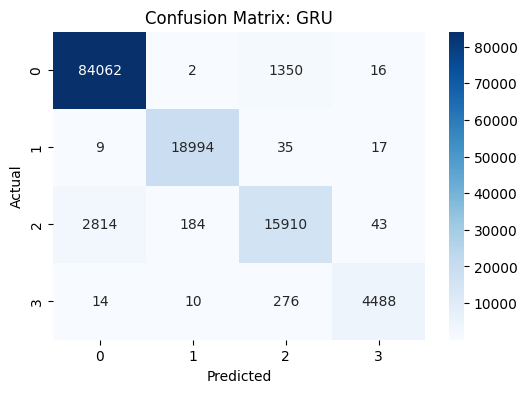

      Model  Accuracy  Precision  Recall  F1-Score  Training Time
0  CNN-LSTM    0.9685     0.9683  0.9685    0.9683       16276.70
1       GRU    0.9628     0.9621  0.9628    0.9622       21059.38


In [16]:
# Εκπαίδευση με URL χαρακτηριστικό
X_train_url, X_test_url, y_train, y_test = train_test_split(padded_urls, y, test_size=0.2, random_state=42)

# Δημιουργία του GRU Μοντέλου
gru_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=128, input_length=max_len),
    GRU(128),             # GRU layer με 128 νευρώνες
    BatchNormalization(), # Κανονικοποίηση για σταθερότητα
    Dropout(0.3),         # Regularization για αποφυγή overfitting
    # Πλήρως συνδεδεμένο επίπεδο
    Dense(64, activation='relu'),
    Dropout(0.3),
    # Τελική έξοδος
    Dense(4, activation='softmax')
])

# Σύνταξη του μοντέλου
gru_model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0005), metrics=['accuracy'])

# Εκπαίδευση και Αξιολόγηση, προσθήκη στη τελική λίστα αποτελεσμάτων
results.append(train_and_evaluate(gru_model, X_train_url, X_test_url, y_train, y_test, 'GRU'))

# Παρουσίαση αποτελεσμάτων
results_df = pd.DataFrame(results, columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'Training Time'])
print(results_df)


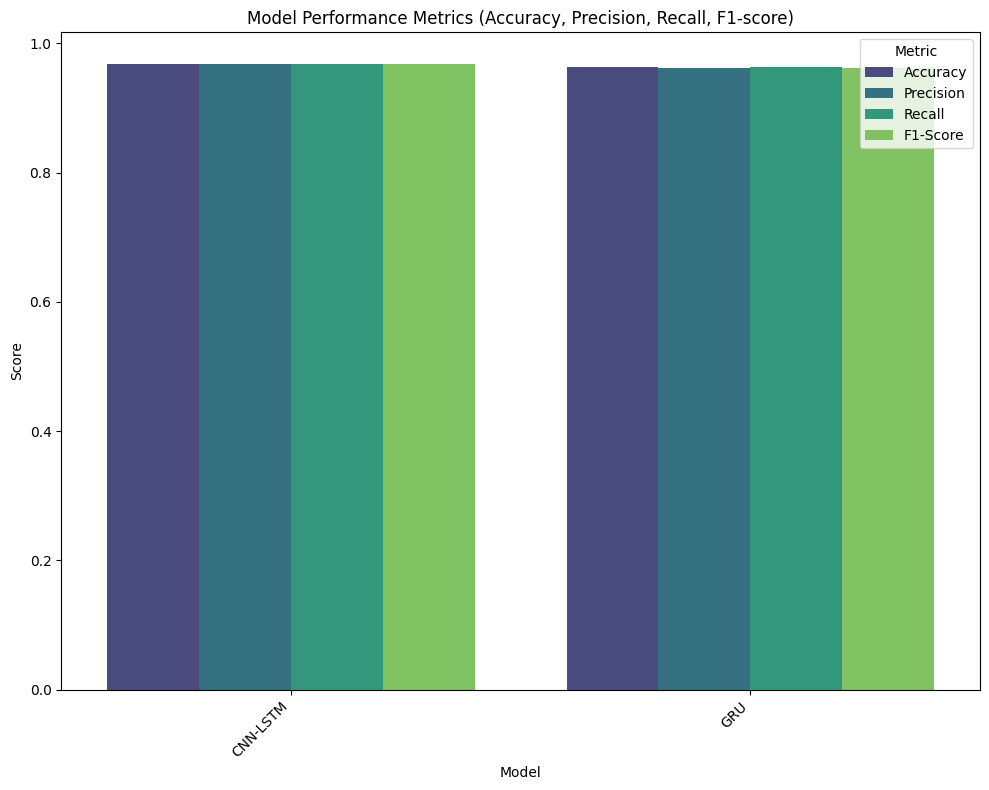

/tmp/ipython-input-3537753896.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Training Time', data=results_df, palette='plasma')


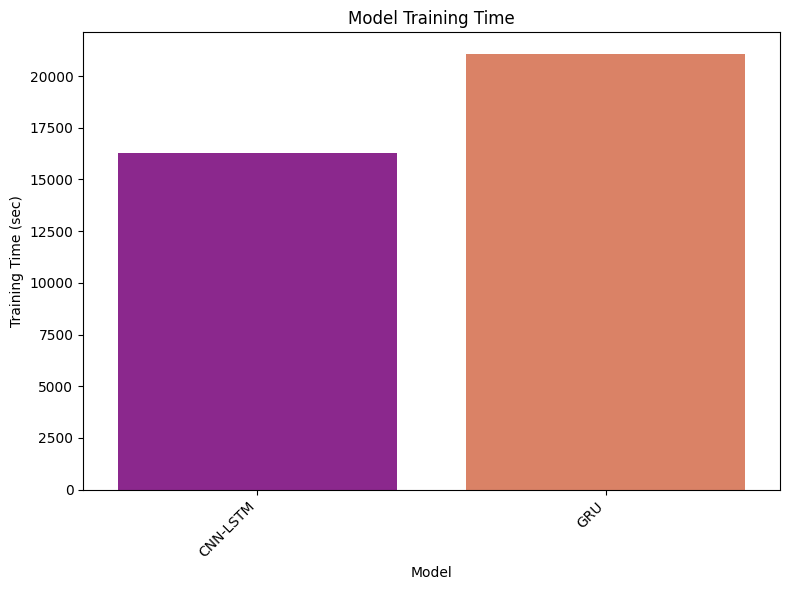

In [18]:
# Διάγραμμα συνολικών αποτελεσμάτων για κάθε μοντέλο (μετρικές και χρόνοι)

# Μετατροπή DataFrame για εύκολη σχεδίαση
results_melt = results_df.melt(
    id_vars='Model',
    value_vars=['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    var_name='Metric',
    value_name='Score'
)

# Διάγραμμα μετρικών
plt.figure(figsize=(10,8))
sns.barplot(x='Model', y='Score', hue='Metric', data=results_melt, palette='viridis')
plt.title('Model Performance Metrics (Accuracy, Precision, Recall, F1-score)')
plt.xlabel('Model')
plt.ylabel('Score')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Metric')
plt.tight_layout()
plt.show()

# Διάγραμμα χρόνου εκπαίδευσης
plt.figure(figsize=(8,6))
sns.barplot(x='Model', y='Training Time', data=results_df, palette='plasma')
plt.title('Model Training Time')
plt.xlabel('Model')
plt.ylabel('Training Time (sec)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()